In [1]:
import os
from os.path import isdir, join

from pathlib import Path
import pandas as pd
import time
#loadmat
from scipy.io import loadmat,savemat

# Math
import numpy as np
from scipy.fftpack import fft, dct
from scipy import signal
from scipy.stats import norm,multivariate_normal
from scipy.io import wavfile
import librosa

from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd

#math
import math

%matplotlib inline

# 1. Import the data

In [2]:
audio_path = "C:\\Users\\hasee\\workspace\\lab\\patRecDat\\forStudents\\timit\\test"
#audio_path = "/Users/Mata/Documents/2017/学习/ws2017:18/PUL/forStudents/timit/test"

In [3]:
def load_data(audio_train_path):
    Name_set={}
    test_set=[]
    count =0
    for area in os.listdir(audio_train_path):#os.listdit: to show the files in this path
        #for name in os.listdir(audio_train_path+'\\'+area+"\\"):
        if (area=='.DS_Store'):
            continue
        else:
            for name in os.listdir(audio_train_path+'/'+area+"/"):
                if (name =='.DS_Store'):
                    continue
                else:
                    Name_set.setdefault(name)  #add new key to the dict
                    sample_set=[]
                    #print (name)
                    #count +=1
                    #print (count)
                    #for files in os.listdir(audio_train_path+'\\'+area+'\\'+name+'\\'):
                    for files in os.listdir(audio_train_path+'/'+area+'/'+name+'/'):
                        #_,samples=wavfile.read(audio_train_path+'\\'+area+'\\'+name+'\\'+files)#read the wavfile , return sample_rate ,and samples
                        _,samples=wavfile.read(audio_train_path+'/'+area+'/'+name+'/'+files)
                        sample_set.append(samples)
                        Name_set[name]=sample_set
    return Name_set


            #Name_set.setdefault(name)

In [4]:
dataset=load_data(audio_path)

In [10]:
data=np.concatenate(dataset.get('mrpc0','no such file'))

In [11]:
data

array([-3,  2,  3, ...,  0, -1,  2], dtype=int16)

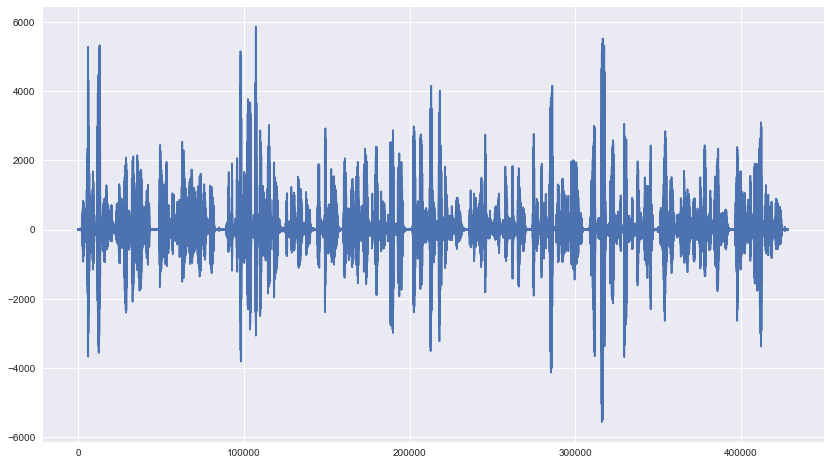

In [12]:
plt.figure(figsize=(14,8))
plt.plot(np.linspace(0,len(data),len(data)),data) 
#np.linspace(): set up 3rd argument to sample_rate,otherwise default=50
plt.show()

# 2. Frame segmentation

In [14]:
sample_rate=16000
t_feed=10 #feed time
t_frame=20 #frame time
fs=sample_rate/1000 #sample_rate of each ms
L_value=np.int(fs*t_frame)
L_value

320

In [15]:
def frame_segment(samples):
    #frame_num = K 
    frame_num=np.int((len(samples)-L_value)/(fs*t_feed))+1 #calculate the number of frames
    frame_set=[]
    for k in range(frame_num):
        frame_set.append(samples[k*np.int(fs*t_feed):k*np.int(fs*t_feed)+L_value])#[0,n] contains 0~n-1
    return frame_set,frame_num

In [16]:
frame_set,frame_num=frame_segment(data)

In [17]:
frame_num

2676

In [18]:
#step1:figure out the noise signal power
mixed_power_set=[]
for k in range(frame_num):
    mixed_power_set.append(1/(L_value)*np.sum((np.float64(frame_set[k]))**2))#use np.float64 to avoid overflow encountered in long scalars
#step2:The noise power
t_n=100
frame_drop=np.int((t_n/t_feed)-1)
no_speech_set=frame_set[:frame_drop]
noise_power_set=(1/frame_drop)*np.sum(no_speech_set)

In [43]:
gamma=10000
selected_power_set=np.array(mixed_power_set).copy()
selected_power_set[selected_power_set<gamma*noise_power_set]=0

In [44]:
selected_power_set

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

try to plot the noise frames and voice frames according to different $\gamma$

In [53]:
def noise_plot(mixed_power_set,noise_power_set,frame_num,gamma=1000):
    plt.figure(figsize=(14,8))
    plt.bar(range(frame_num),mixed_power_set)#plt,bar(index,height(value))
    selected_power_set=np.array(mixed_power_set).copy()
    selected_power_set[selected_power_set<gamma*noise_power_set]=0
    plt.bar(range(frame_num),selected_power_set,color='red')
    plt.hlines( gamma*noise_power_set, 0, frame_num,label ="$\gamma$ %5.1f"%(gamma), linestyles = "dashed" )
    
    plt.legend()
    plt.ylabel("amplitude",fontsize=20)
    plt.xlabel("frame_num",fontsize=20)
    plt.title( 'step 3 at different $\gamma$',fontsize=25 )
    plt.show()

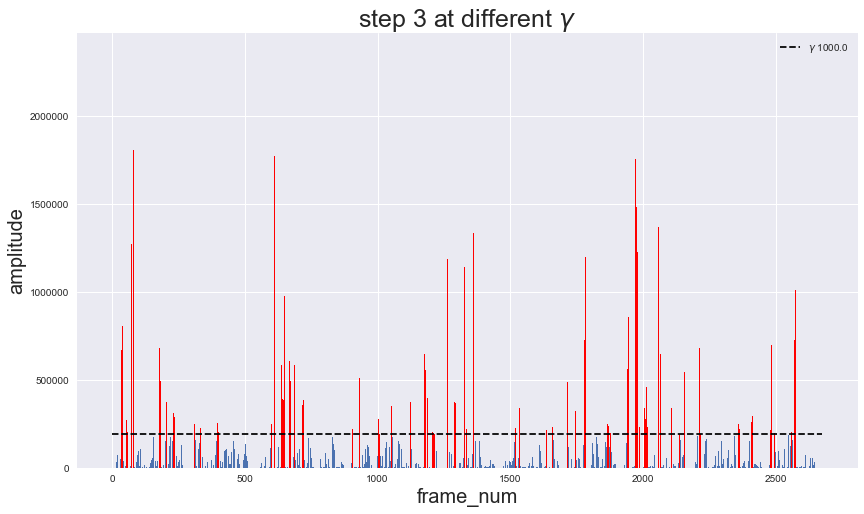

In [54]:
noise_plot(mixed_power_set,noise_power_set,frame_num)